Denoising Autoencoder Using Tensorflow

In [48]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt

Xavier_initalizer:

In [4]:
def xavier_init(num_in, num_out):
    low = - np.sqrt(6.0 / (num_in + num_out))
    high = - low
    return tf.random_uniform((num_in, num_out), low, high)

In [57]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, layers_units, activation = tf.nn.relu, optimizer = tf.train.AdamOptimizer(0.01), noise_scale = 0.1):
        assert layers_units[0] == layers_units[-1], 'the units of the first and the last layer should be same'
        self.layers_units = layers_units
        self.activation = activation
        self.weights = self._initialize_weights()
        self.input_layer = tf.placeholder(tf.float32, [None, self.layers_units[0]])
        self.output_layer = self.input_layer + noise_scale * tf.random_normal((layers_units[0],)) # add gaussian noise
        for i in range(1,len(self.layers_units)): # build the network
            self.output_layer = self.activation(tf.matmul(self.output_layer,self.weights['w'+str(i)]) + self.weights['b'+str(i)])
        self.cost = tf.reduce_mean(tf.square(self.output_layer - self.input_layer)) #MSE
        self.optimizer = optimizer.minimize(self.cost)
        
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
    
    def _initialize_weights(self):
        weights = {}
        num_layers = len(self.layers_units)
        for i in range(1, num_layers): # there are no weights for the input layer
            weights['w' + str(i)] = tf.Variable(xavier_init(self.layers_units[i - 1], self.layers_units[i]), dtype = tf.float32)
            weights['b' + str(i)] = tf.Variable(tf.random_normal([self.layers_units[i]]), dtype = tf.float32)
        return weights
    
    def train(self, X_input):
        cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict = {self.input_layer : X_input})
        return cost
    
    def eval_cost(self, X_input):
        return self.sess.run([self.cost], feed_dict = {self.input_layer : X_input})
    
    def eval_output(self, X_input):
        return self.sess.run([self.output_layer], feed_dict = {self.input_layer : X_input})

In [9]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

In [11]:
def get_random_batch_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index : start_index + batch_size]

The main training process:

In [12]:
X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

In [16]:
epochs = 20
n_samples = int(mnist.train.num_examples)
batch_size = 128
show_step = 1
learning_rate = 0.001

In [58]:
autoencoder = AdditiveGaussianNoiseAutoencoder([784,200,784], tf.nn.relu, tf.train.AdamOptimizer(learning_rate), 0.01)
for epoch in range(epochs):
    avg_cost = 0
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        X_train_batch = get_random_batch_from_data(X_train, batch_size)
        cost = autoencoder.train(X_train_batch)
        avg_cost += cost * batch_size / n_samples
    if epoch % show_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), " Cost=", '%.6f' % avg_cost)

Epoch: 0001  Cost= 0.686696
Epoch: 0002  Cost= 0.558509
Epoch: 0003  Cost= 0.533818
Epoch: 0004  Cost= 0.516251
Epoch: 0005  Cost= 0.515279
Epoch: 0006  Cost= 0.485238
Epoch: 0007  Cost= 0.498050
Epoch: 0008  Cost= 0.504674
Epoch: 0009  Cost= 0.507450
Epoch: 0010  Cost= 0.506458
Epoch: 0011  Cost= 0.506997
Epoch: 0012  Cost= 0.488578
Epoch: 0013  Cost= 0.501301
Epoch: 0014  Cost= 0.479638
Epoch: 0015  Cost= 0.503186
Epoch: 0016  Cost= 0.491378
Epoch: 0017  Cost= 0.500065
Epoch: 0018  Cost= 0.495138
Epoch: 0019  Cost= 0.481231
Epoch: 0020  Cost= 0.504429


In [63]:
def random_visualize(autoencoder, X):
    index = np.random.randint(0, X.shape[0])
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(X[index], (28,28)))
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(autoencoder.eval_output([X[index]]), (28,28)))

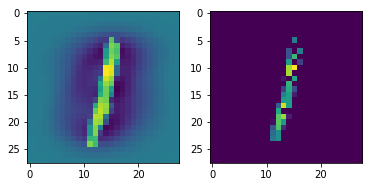

In [64]:
random_visualize(autoencoder, X_test)